In [1]:
execution_mode = 'tune'

# Support Vector Classifier Model

After the Ensemble model family, a Support Vector Classifier shall be calculated in this chapter. The Support Vector Classifier will be modeled in two modes. The first mode will be without cross-validation, while the second mode will be with cross-validation. The structure of this chapter will be the same to the structure drawn in the preceding chapter.

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Support Vector Classifier](#Support-Vector-Classifier)
    - [Train/Test Split for Support Vector Classifier](#Train/Test-Split-for-Support-Vector-Classifier)
    - [Model Training for Support Vector Classifier](#Model-Training-for-Support-Vector-Classifier)
    - [Performance Measurement of Support Vector Classifier](#Performance-Measurement-of-Support-Vector-Classifier)
    - [Model Interpretation of Support Vector Classifier](#Model-Interpretation-of-Support-Vector-Classifier)
- [Support Vector Classifier with Cross-Validation](#Support-Vector-Classifier-with-Cross-Validation)
    - [Train/Test Split for Support Vector Classifier CV](#Train/Test-Split-for-Support-Vector-Classifier-CV)
    - [Model Training for Support Vector Classifier CV](#Model-Training-for-Support-Vector-Classifier-CV)
    - [Performance Measurement of Support Vector Classifier CV](#Performance-Measurement-of-Support-Vector-Classifier-CV)
    - [Model Interpretation of Support Vector Classifier CV](#Model-Interpretation-of-Support-Vector-Classifier-CV)
- [Summary](#Summary)
    - [Results Handover](#Results-Handover)

## Data Takeover

The data from chapters [Feature Matrix Generation](./4_FeatureMatrixGeneration.ipynb) and [Features Discussion and Dummy Classifier Baseline](./5_FeatureDiscussionDummyBaseline.ipynb) have to be read in as input for processing in this chapter.

In [2]:
import os
import pandas as pd
import bz2
import _pickle as cPickle

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

# Restore DataFrame with features from compressed pickle file
with bz2.BZ2File((os.path.join(
    path_goldstandard, 'labelled_feature_matrix_full.pkl')), 'rb') as file:
    df_attribute_with_sim_feature = cPickle.load(file)

df_labelled_feature_matrix.head()

,coordinate_E_delta,coordinate_N_delta,corporate_full_delta,doi_delta,edition_delta,exactDate_delta,format_prefix_delta,format_postfix_delta,isbn_delta,ismn_delta,...,part_delta,person_100_delta,person_700_delta,person_245c_delta,pubinit_delta,scale_delta,ttlfull_245_delta,ttlfull_246_delta,volumes_delta,duplicates
0,-1.0,-1.0,-1.0,-0.5,-1.0,0.500,1.0,0.111111,1.0,-1.0,...,-0.500000,0.492677,-0.500000,0.501852,-0.500000,-1.0,0.583840,-1.0,-0.5,0
1,-1.0,-1.0,-1.0,-1.0,-1.0,0.375,0.0,0.111111,0.0,-1.0,...,-1.000000,-0.500000,-0.500000,-0.500000,0.431481,-1.0,0.581389,-0.5,-0.5,0
2,-1.0,-1.0,-0.5,-1.0,-0.5,0.250,1.0,1.000000,0.0,-1.0,...,-1.000000,-0.500000,0.595726,0.512821,-0.500000,-1.0,0.527260,-1.0,-0.5,0
3,-1.0,-1.0,-1.0,-1.0,-1.0,0.750,1.0,1.000000,0.0,-1.0,...,0.537037,1.000000,0.517857,0.682481,-0.500000,-1.0,0.534578,-1.0,0.0,0
4,-1.0,-1.0,-0.5,-1.0,-0.5,0.250,0.0,0.111111,0.0,-1.0,...,-0.500000,1.000000,0.648301,0.706674,-0.500000,-1.0,1.000000,-1.0,0.0,0


In [3]:
print('Part of duplicates (1) and uniques (0) in units of [%]')
print(round(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100, 2))

Part of duplicates (1) and uniques (0) in units of [%]
0    98.59
1     1.41
Name: duplicates, dtype: float64


## Support Vector Classifier

A Support Vector Machine allows the use of regularization. To get an idea on its basic behaiour, a first model with grid search but without cross-validation will be calculated.

### Train/Test Split for Support Vector Classifier

All three data sets like for training, validation and testing have to be generated by splitting the raw data.

In [4]:
import classifier_fitting_funcs as cff

X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, idx_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.375     ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       ,  0.53717949,  0.49234099,
          0.48232323, -1.        ,  0.57057231, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  1.        ,  0.42857143,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -1.        ,  0.56825397, -1.        ,  0.55555556],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
          0.41282051, -1.        ,  0.58290694, -0.5       , -0.5       ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        , 

In [5]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(66979, 20) (66979,) (16745, 20) (16745,) (20931, 20) (20931,)
The test data set holds 20636 records of uniques and 295 records of duplicates.


### Model Training for Support Vector Classifier

The parameter space for grid search is specific for Support Vector Classifiers.

In [6]:
if execution_mode == 'manual' :
    parameter_dictionary = {
        'kernel' : ['poly'],
        'degree' : [3],
        'gamma' : [2.0],
        'C' : [0.5],
        'class_weight' : [None]
    }
elif execution_mode == 'full' :
    # Kernel 'rbf' has long calculation times, but does not generate
    #  the best accuracy : Ommit in grid search.
    parameter_dictionary = {
        'kernel' : ['poly'],
        'degree' : [2, 3, 4],
        'gamma' : [0.01, 0.1, 1.0],
        'C' : [0.1, 1.0, 10.0],
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    parameter_dictionary = {
        'kernel' : ['poly'],
        'degree' : [3],
        'gamma' : [1.0],
        'C' : [1.0],
        'class_weight' : [None]
    }
elif execution_mode == 'tune' :
    parameter_dictionary = {
        'kernel' : ['poly'],
        'degree' : [3],
        'gamma' : [0.4, 0.5, 0.6, 0.7, 0.8],
        'C' : [1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5],
        'class_weight' : [None]
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
kernel ['poly']
degree [3]
gamma [0.4, 0.5, 0.6, 0.7, 0.8]
C [1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
class_weight [None]
 => Number of combinations : 35


The classifiers are fitted on each point of the grid.

In [7]:
from sklearn.svm import SVC

sv = SVC(random_state=0)

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(sv, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_sv = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'C': 1.2, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.2, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.881%
Fitting with parameters {'C': 1.2, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.904%
Fitting with parameters {'C': 1.2, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.2, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.25, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.25, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.881%
Fitting with parameters {'C': 1.25, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.904%
Fitting with parameters {'C': 1.25, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.25, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.3, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.3, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.881%
Fitting with parameters {'C': 1.3, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.904%
Fitting with parameters {'C': 1.3, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.3, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.35, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.35, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.881%
Fitting with parameters {'C': 1.35, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.35, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.35, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.4, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.4, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.881%
Fitting with parameters {'C': 1.4, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.4, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.4, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.45, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.45, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.45, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.45, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.45, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.5, 'class_weight': None, 'degree': 3, 'gamma': 0.4, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.5, 'class_weight': None, 'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}


 => validation score 99.887%
Fitting with parameters {'C': 1.5, 'class_weight': None, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'}


 => validation score 99.898%
Fitting with parameters {'C': 1.5, 'class_weight': None, 'degree': 3, 'gamma': 0.7, 'kernel': 'poly'}


 => validation score 99.893%
Fitting with parameters {'C': 1.5, 'class_weight': None, 'degree': 3, 'gamma': 0.8, 'kernel': 'poly'}


 => validation score 99.898%


The parameters for the best estimator of Support Vector Classifier without cross-validation are shown below.

In [8]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

# Create a decision tree
sv_best = SVC(gamma=best_params['gamma'], kernel=best_params['kernel'],
              C=best_params['C'], class_weight=best_params['class_weight'],
              degree=best_params['degree'], random_state=0
             )

# Fit estimator
sv_best.fit(X_tr, y_tr)

The parameters for the best model are ...
kernel = poly
degree = 3
gamma = 0.6
C = 1.2
class_weight = None


SVC(C=1.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.6, kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Performance Measurement of Support Vector Classifier

The performance measurement of the best estimator is done as described in chapter [Decision Tree Model](./6_DecisionTreeModel.ipynb) and is shown without any further comment.

In [9]:
from sklearn.metrics import confusion_matrix

y_pred_sv = sv_best.predict(X_te)

confusion_matrix(y_te, y_pred_sv)

array([[20617,    19],
       [   24,   271]])

In [10]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('Score {:.3f}%'.format(100*sv_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(100*roc_auc_score(y_te, y_pred_sv),
                100*accuracy_score(y_te, y_pred_sv),
                100*precision_score(y_te, y_pred_sv),
                100*recall_score(y_te, y_pred_sv)
               ))

Score 99.795%
Area under the curve 95.886% - accuracy 99.795% - precision 93.448% - recall 91.864%


The wrongly classified records of this classifier have to be persisted for assessment in chapter [Overview and Summary](./0_OverviewSummary.ipynb).

In [11]:
import results_analysis_funcs as raf
import results_saving_funcs as rsf

idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_sv)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              sv_best, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]])

### Model Interpretation of Support Vector Classifier

The Support Vector Classifier object of scikit-learn has a member function $\texttt{.decision}\_\texttt{function}()$. This function returns the distance of a record's point from the hyperplane of separation. To get an understanding of this idea, let's have a look at the graph below.

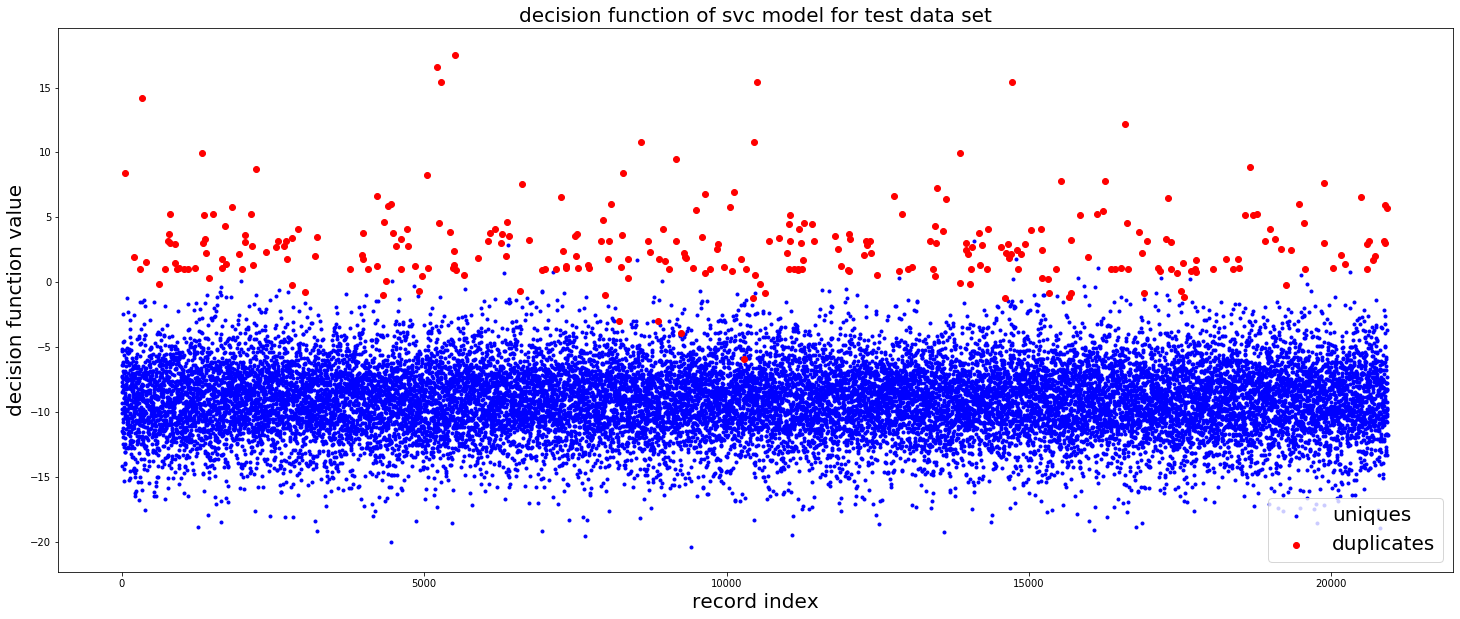

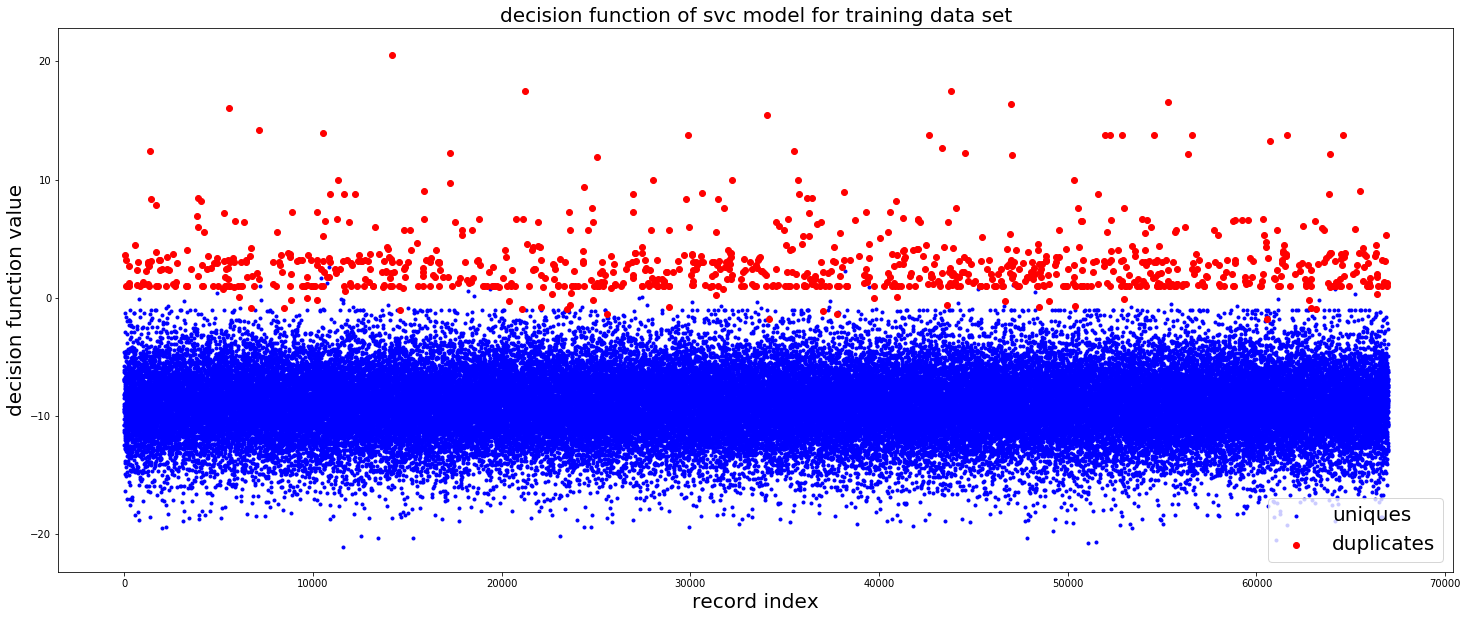

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_function(X, y, title):
    index = np.arange(len(y))
    classes = ['uniques', 'duplicates']
    classes_indexes = [y==0, y==1]
    marker_size = ['.', 'o']
    colors = ['blue', 'red']
    font_size = 20

    plt.subplots(figsize=(25, 10))
    for c in range(len(classes)) :
        plt.scatter(index[classes_indexes[c]],
                    sv_best.decision_function(X[classes_indexes[c]]),
                    marker=marker_size[c], color=colors[c], label=classes[c])
    plt.xlabel('record index', fontsize=font_size)
    plt.ylabel('decision function value', fontsize=font_size)
    plt.title(title, fontsize=font_size)
    plt.legend(fontsize=font_size, loc='lower right')
    plt.show()

plot_decision_function(X_te, y_te, 'decision function of svc model for test data set')
plot_decision_function(X_tr, y_tr, 'decision function of svc model for training data set')

The first plot with title 'decision function of svc model for test data set' shows the decision function distributions of the estimator for records of pairs of uniques (blue colour) and for records of pairs of duplicates (red colour) for the test data set. The second plot with title 'decision function of svc model for training data set' shows the decision function distributions of the model for the records of the training data set. In both plots, a clear separation between the mass of red and the mass of blue points can be observed. Only a minority of points are spread in the area of the wrong side. These points are the exceptions. The red and the blue points are separated by a fine white line. This line is represented by the decision function value $y=0$. The hyperplane of the Support Vector Classifier separates the records of uniques from the records of duplicates with the help of this hyperplane. To prove this hypothesis, let's have a look at the third plot below.

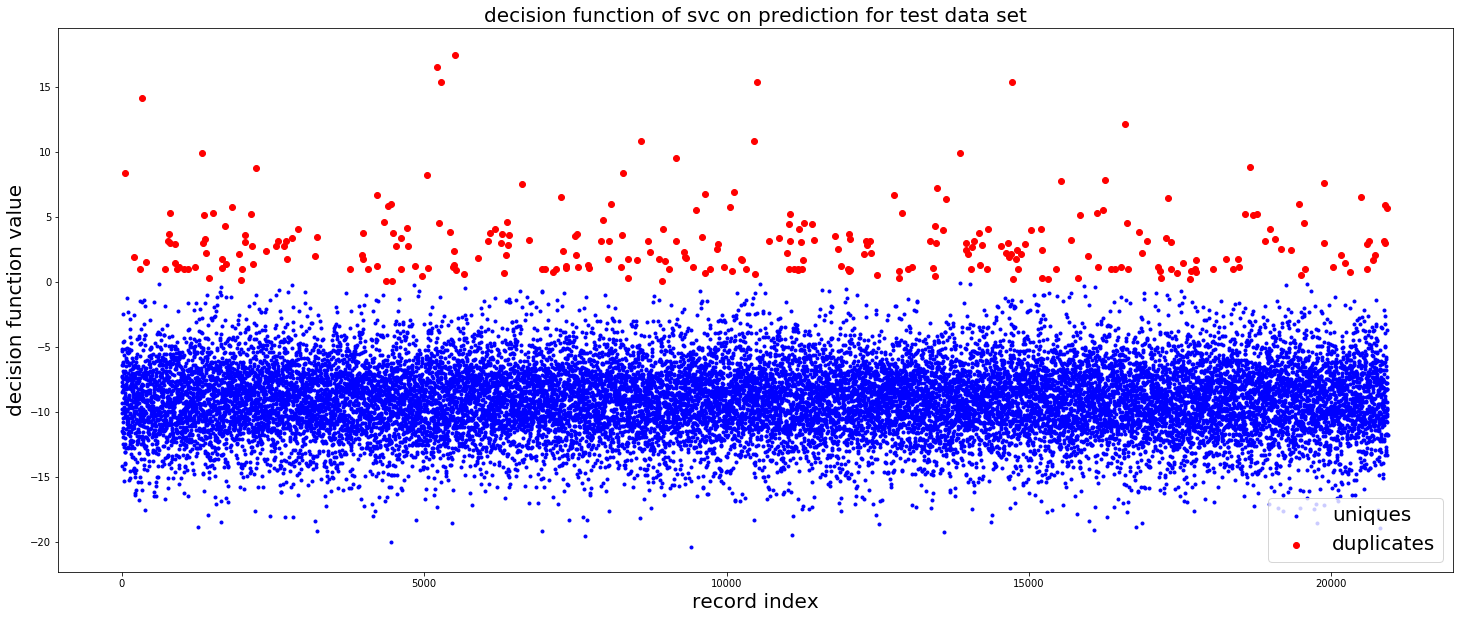

In [13]:
plot_decision_function(X_te, y_pred_sv, 'decision function of svc on prediction for test data set')

In the plot above, the model has done the classification of unique and duplicate and the given classification of the test data has been ignored. This plot shows no exception point, there is neither a single red point in the blue (negative) region nore a blue point in the red (positive) region. This is confirmed by the result of the following code cell.

In [14]:
classes = ['uniques', 'duplicates']
classes_indexes = [y_pred_sv==0, y_pred_sv==1]

for c in range(len(classes)):
    print('Interval range of {} [{:.3f}, {:.3f}]'.format(classes[c],
        min(sv_best.decision_function(X_te[classes_indexes[c]])),
        max(sv_best.decision_function(X_te[classes_indexes[c]]))))

Interval range of uniques [-20.412, -0.099]
Interval range of duplicates [0.058, 17.528]


The first plot of this subsection with the title 'decision function of svc model for test data set' illustrates the result of the confusion matrix of subsection [Performance Measurement for Support Vector Classifier](#Performance-Measurement-for-Support-Vector-Classifier), above. The red points in the negative half plane are the false positives, while the blue points in the positive half plane are the false negatives.

## Support Vector Classifier with Cross-Validation

Another Support Vector Classifier shall be fitted, now with the use of cross-validation in order to harden the result of the first model statistically.

### Train/Test Split for Support Vector Classifier CV

Cross-validation with object $\texttt{GridSearchCV}$ from scikit-learn splits the training data into training and validation parts. It is sufficient to split the original data into a train and a test data set without any additional splitting of the training data.

In [15]:
X_tr, _, X_te, y_tr, _, y_te, idx_tr, _, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.375     ,  1.        ,  0.42857143,  1.        , -1.        ,
         -1.        , -1.        ,  0.59267881, -1.        , -0.5       ,
         -0.5       , -1.        ,  0.52393162, -1.        , -0.5       ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.25      ,  0.        ,  0.11111111,  1.        , -1.        ,
         -1.        , -1.        , -0.5       ,  0.56565657, -0.5       ,
          0.30112045, -1.        ,  0.78571429, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  1.        ,  0.42857143,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       ,  0.46666667,  0.50483281,
         -0.5       , -1.        ,  0.62225886, -1.        ,  0.51111111],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  0.        , 

In [16]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(83724, 20) (83724,) (20931, 20) (20931,)
The test data set holds 20636 records of uniques and 295 records of duplicates.


### Model Training for Support Vector Classifier CV

The parameter grid remains the same as with the model above.

In [17]:
from sklearn.model_selection import GridSearchCV

# Create cross-validation object with DecisionTreeClassifer
grid_cv = GridSearchCV(SVC(random_state=0),
                       param_grid = parameter_dictionary, cv=5
                       , verbose=1
                      )

# Fit estimator
grid_cv.fit(X_tr, y_tr)

# Get the results with 'cv_results_', get parameters with their scores
params = pd.DataFrame(grid_cv.cv_results_['params'])
scores = pd.DataFrame(grid_cv.cv_results_['mean_test_score'], columns=['accuracy_val'])
log_scores = pd.DataFrame(-np.log(1-grid_cv.cv_results_['mean_test_score']), columns=['log_accuracy_val'])
scores_std = pd.DataFrame(grid_cv.cv_results_['std_test_score'], columns=['std_accuracy_val'])

# Create a DataFrame of (parameters, score, std) pairs
df_test_scores_svcv = params.merge(scores, how='inner', left_index=True, right_index=True)
df_test_scores_svcv = df_test_scores_svcv.merge(
    scores_std, how='inner', left_index=True, right_index=True).sort_values(
    'accuracy_val', ascending=False)
df_test_scores_svcv = df_test_scores_svcv.merge(
    log_scores, how='inner', left_index=True, right_index=True)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  6.5min finished


In [18]:
df_test_scores_svcv

,C,class_weight,degree,gamma,kernel,accuracy_val,std_accuracy_val,log_accuracy_val
2,1.20,None,3,0.6,poly,0.998388,0.000309,6.430005
12,1.30,None,3,0.6,poly,0.998352,0.000331,6.408027
26,1.45,None,3,0.5,poly,0.998352,0.000299,6.408027
17,1.35,None,3,0.6,poly,0.998340,0.000349,6.400807
22,1.40,None,3,0.6,poly,0.998340,0.000349,6.400807
31,1.50,None,3,0.5,poly,0.998340,0.000286,6.400807
7,1.25,None,3,0.6,poly,0.998340,0.000334,6.400806
27,1.45,None,3,0.6,poly,0.998328,0.000368,6.393638
32,1.50,None,3,0.6,poly,0.998328,0.000368,6.393638
21,1.40,None,3,0.5,poly,0.998328,0.000320,6.393638


The best estimator is shown below.

In [19]:
svcv_best = grid_cv.best_estimator_
svcv_best

SVC(C=1.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.6, kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Performance Measurement of Support Vector Classifier CV

The structure of this subsection has been described previously and remains the same like for all models.

In [20]:
y_pred_svcv = svcv_best.predict(X_te)

confusion_matrix(y_te, y_pred_svcv)

array([[20620,    16],
       [   21,   274]])

In [21]:
print('Score {:.3f}%'.format(100*svcv_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(
    100*roc_auc_score(y_te, y_pred_svcv),
                100*accuracy_score(y_te, y_pred_svcv),
                100*precision_score(y_te, y_pred_svcv),
                100*recall_score(y_te, y_pred_svcv)
               ))

Score 99.823%
Area under the curve 96.402% - accuracy 99.823% - precision 94.483% - recall 92.881%


For results comparison, the wrongly classified records need to be persisted.

In [22]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_svcv)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              svcv_best, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]], '_CV')

### Model Interpretation of Support Vector Classifier CV

The Support Vector Classifier object of scikit-learn has a member function $\texttt{.predict}\_\texttt{proba}()$. This function can only be called, if parameter $\texttt{probability}=\texttt{True}$ is set for the classifier instance [[svc](./A_References.ipynb#svc)]. It returns the probabilities of a record to be predicted to the class of uniques and the class of duplicates. As there are two distinct classes for this capstone project, the result of function $\texttt{.predict}\_\texttt{proba}()$ is a two-dimensional array. The components of each array sum up to a value of 1.

In [23]:
# Execute only in local run mode due to runtime needed which is double compared to the default object (probability=False)
if execution_mode == 'manual' :
    grid_cvp = GridSearchCV(SVC(random_state=0, probability=True),
                           param_grid = parameter_dictionary, cv=5
                           , verbose=1
                          )

    # Fit estimator
    grid_cvp.fit(X_tr, y_tr)
    # Predict
    y_pred_proba = grid_cvp.best_estimator_.predict_proba(X_te)

The graph below shows two plots. The first plot is the prediction of the classifier for each record of the test data set that the record belongs to class 'unique'. The second plot is the complementary probability. Each plot shows a green line at a probability value of 0.5. This is the threshold, explained in chapter [Decision Tree Model](./6_DecisionTreeModel.ipynb).

In [24]:
def p(X, y, pred, title):
    index = np.arange(len(y))
    classes = ['uniques', 'duplicates']
    classes_indexes = [y==0, y==1]
    marker_size = ['.', 'o']
    colors = ['blue', 'red']
    font_size = 20

    plt.subplots(figsize=(25, 10))
    for c in range(len(classes)) :
        plt.scatter(index[classes_indexes[c]],
                    pred[classes_indexes[c]],
                    marker=marker_size[c], color=colors[c], label=classes[c])
    plt.axhline(y=0.5, color='green', label='threshold')
    plt.xlabel('record index', fontsize=font_size)
    plt.ylabel('probability', fontsize=font_size)
    plt.title(title, fontsize=font_size)
    plt.legend(fontsize=font_size, loc='lower right')
    plt.show()

if execution_mode == 'manual' :
    p(X_te, y_te, y_pred_proba[:,0], 'probability of svc on prediction of label \'unique\' for test data set')
    p(X_te, y_te, y_pred_proba[:,1], 'probability of svc on prediction of label \'duplicate\' for test data set')

**Remark** Unfortunately, the number of false positives and the number of false negatives of the predicted data is different from the numbers shown in the confusion matrix for the classifier, cp. subsection [Performance Measurement of Support Vector Classifier CV](#Performance-Measurement-of-Support-Vector-Classifier-CV). A difference between two classifiers, one with $\texttt{probability}=\texttt{False}$ and one with $\texttt{probability}=\texttt{True}$ may be expected as documented in [[svc](./A_References.ipynb#svc)].

The plots above show a distribution of points according to their predicted classification. Most of the points that represent records of uniques (blue colour), are predicted close to a probability value of 1.0 in the upper plot and 0.0 in the lower plot. For the records of duplicates, the distribution is vice versa. The plots become interesting for the distribution of the points far away from the interval borders of $[0, 1]$. The classifier is not clearly decided for these points and their classification is decided by the threshold (green line). The green line is the separator of the blue and red coloured points with the least amount of records assigned to its wrong side. The graph illustrates the meaning of the threshold for the characteristic numbers of the confusion matrix. Moving the threshold in either direction may change the number of false predicted records, but also the number of true predicted records. This change will have a decreasing effect on the accuracy but may have an increasing effect on the other characteristic numbers of the confusion matrix.

To go deeper in the interpretation of the Support Vector Classifier model, it would be nice to be able to calculate the classification probability for a specific record. Unfortunately, this can only be done for an Support Vector Classifier model with linear kernel. In the code cell below, an object $\texttt{LinearSVC}$ is instantiated due to calculation time of the fit which is much lower for this object than for an object $\texttt{SVC}(\texttt{random_state=0, probability=True, kernel='linear'})$. The results of the two objects are slightly different but similar enough to illustrate the idea to come below.

In [25]:
from sklearn.svm import LinearSVC

svc_lin = LinearSVC(random_state=0)
svc_lin.fit(X_tr, y_tr)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

The Support Vector Classifier object with linear kernel holds an array of coefficients as an attribute. These coefficients describe the hyperplane of separation of the records' points in the linear space. Plotting these coefficients of the estimator gives the weight of a feature in the prediction calculation of a record. As the features of the feature matrix lie in the interval $[0, 1]$ (with negative values $\ge -1$ for missing values), they can be considered as scaled and the coefficients's heights may be compared. The height of a coefficient may be interpreted as its importance for prediction.

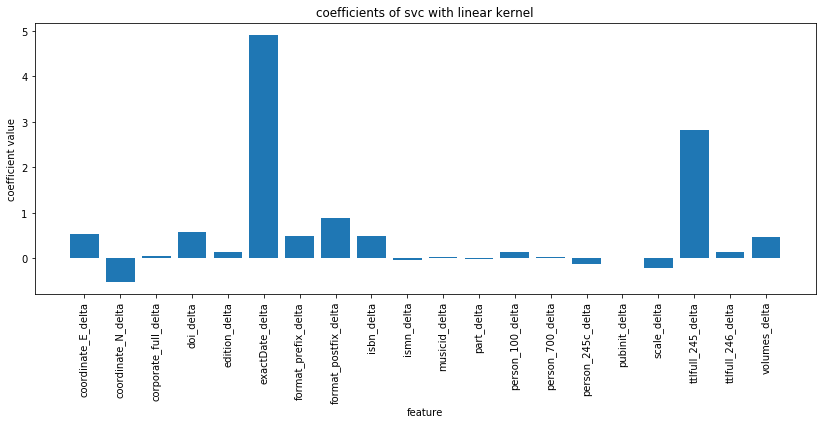

In [26]:
plt.subplots(figsize=(14, 5))
plt.bar(df_labelled_feature_matrix.columns.drop('duplicates').to_list(), svc_lin.coef_[0])
plt.title('coefficients of svc with linear kernel')
plt.xlabel('feature')
plt.ylabel('coefficient value')
plt.xticks(rotation='vertical')
plt.show()

The bar plot above may be compared to the feature importance plot in chapter [Decision Tree Model](./6_DecisionTreeModel.ipynb#Model-Interpretation-of-Random-Forests).

The author has tried to go deeper in the interpretation of the Support Vector Classifier model, like plotting borders together with their margins between the classes in the two-dimensional plane of two specific features. These efforts have lead to little added value in understanding the model. One reason originates in the fact that the feature space has a dimensionality of 20, another one is based on the fact that the best estimator's kernel is non-linear. Therefore, the efforts stop at this point.

## Summary

This chapter shows the modelling and the performance of Support Vector Classifiers with regularization. The final comparison of the results of this chapter with the results of all other models will be done in [Overview and Summary](./0_OverviewSummary.ipynb).

### Results Handover

For a consolidated view of all results, the performance of both Support Vector Classifiers of this chapter have to be stored.

In [27]:
path_results = './results'

rsf.add_result_to_results(path_results,
                          df_test_scores_sv, sv_best, X_te, y_te, y_pred_sv)
rsf.add_result_to_results(path_results, 
                          df_test_scores_svcv, svcv_best, X_te, y_te, y_pred_svcv, '_CV')